In [1]:
import pandas as pd 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import math
from sklearn import ensemble, model_selection, datasets, metrics, tree 
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

matplotlib.style.use('ggplot')
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Считываем данные
data = pd.read_excel('Data_for_NN.xlsx', skiprows = [0, 1])

In [3]:
data.head(10)

,Target,Time,Call_centre_lvl,Age,First_contract,Gender,Problem,Region,Emotionality
0,0,2020-02-20 17:19:45.313,0.396821,0.769557,Более 5 лет,Ж,2,7.0,0.225755
1,0,2020-02-18 19:53:29.366,0.396821,0.754719,Более 5 лет,Ж,2,9.0,0.214754
2,0,2020-02-21 20:58:30.873,0.396821,0.757050,Более 5 лет,Ж,2,9.0,0.212734
3,0,2020-02-16 21:43:51.866,0.396821,0.752471,Более 5 лет,Ж,2,9.0,0.205210
4,0,2020-02-13 20:15:36.014,0.396821,0.760621,Более 5 лет,Ж,2,9.0,0.207274
5,0,2020-02-14 16:23:08.033,0.396821,0.766439,Более 5 лет,Ж,2,7.0,0.226284
6,0,2020-02-12 11:16:17.972,0.396821,0.752146,Более 5 лет,Ж,2,7.0,0.260786
7,0,2020-02-15 15:06:48.013,0.396821,0.464891,Новый,Ж,6,28.0,0.000000
8,0,2020-02-21 06:58:32.497,0.396821,0.836371,Более 10 лет,Ж,6,8.0,0.376900
9,0,2020-02-20 04:02:17.889,0.396821,0.827804,Более 10 лет,Ж,6,8.0,0.380974


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4997 entries, 0 to 4996
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Target           4997 non-null   int64         
 1   Time             4997 non-null   datetime64[ns]
 2   Call_centre_lvl  4997 non-null   float64       
 3   Age              4997 non-null   float64       
 4   First_contract   4997 non-null   object        
 5   Gender           4997 non-null   object        
 6   Problem          4997 non-null   int64         
 7   Region           4997 non-null   float64       
 8   Emotionality     4997 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 351.5+ KB


In [5]:
#Обработаем тип datetime64
data.Time = data.Time.apply(pd.to_datetime)
data['mon'] = data.Time.apply(lambda x : x.month)
data['hour'] = data.Time.apply(lambda x : x.hour)

In [6]:
data.head(10)

,Target,Time,Call_centre_lvl,Age,First_contract,Gender,Problem,Region,Emotionality,mon,hour
0,0,2020-02-20 17:19:45.313,0.396821,0.769557,Более 5 лет,Ж,2,7.0,0.225755,2,17
1,0,2020-02-18 19:53:29.366,0.396821,0.754719,Более 5 лет,Ж,2,9.0,0.214754,2,19
2,0,2020-02-21 20:58:30.873,0.396821,0.757050,Более 5 лет,Ж,2,9.0,0.212734,2,20
3,0,2020-02-16 21:43:51.866,0.396821,0.752471,Более 5 лет,Ж,2,9.0,0.205210,2,21
4,0,2020-02-13 20:15:36.014,0.396821,0.760621,Более 5 лет,Ж,2,9.0,0.207274,2,20
5,0,2020-02-14 16:23:08.033,0.396821,0.766439,Более 5 лет,Ж,2,7.0,0.226284,2,16
6,0,2020-02-12 11:16:17.972,0.396821,0.752146,Более 5 лет,Ж,2,7.0,0.260786,2,11
7,0,2020-02-15 15:06:48.013,0.396821,0.464891,Новый,Ж,6,28.0,0.000000,2,15
8,0,2020-02-21 06:58:32.497,0.396821,0.836371,Более 10 лет,Ж,6,8.0,0.376900,2,6
9,0,2020-02-20 04:02:17.889,0.396821,0.827804,Более 10 лет,Ж,6,8.0,0.380974,2,4


In [7]:
#Отделим категориальные признаки и вещественные
categorical_cols = ['First_contract', 'Gender']
numeric_cols = list(set(data.columns.values.tolist()) - set(categorical_cols + ['Target'] + ['Time']))

In [8]:
data[numeric_cols].describe()

,Region,hour,mon,Age,Emotionality,Problem,Call_centre_lvl
count,4997.000000,4997.000000,4997.000000,4997.000000,4997.000000,4997.000000,4997.000000
mean,14.773864,11.409846,6.268961,0.629736,0.236079,2.540324,0.468680
std,4.625539,6.906510,2.676758,0.072633,0.186337,1.089575,0.222396
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,5.000000,4.000000,0.599731,0.000000,2.000000,0.360371
50%,15.000000,11.000000,6.000000,0.638006,0.272433,2.000000,0.468328
75%,16.000000,17.000000,9.000000,0.670053,0.357386,3.000000,0.590645
max,100.000000,23.000000,11.000000,1.000000,1.000000,10.000000,1.000000


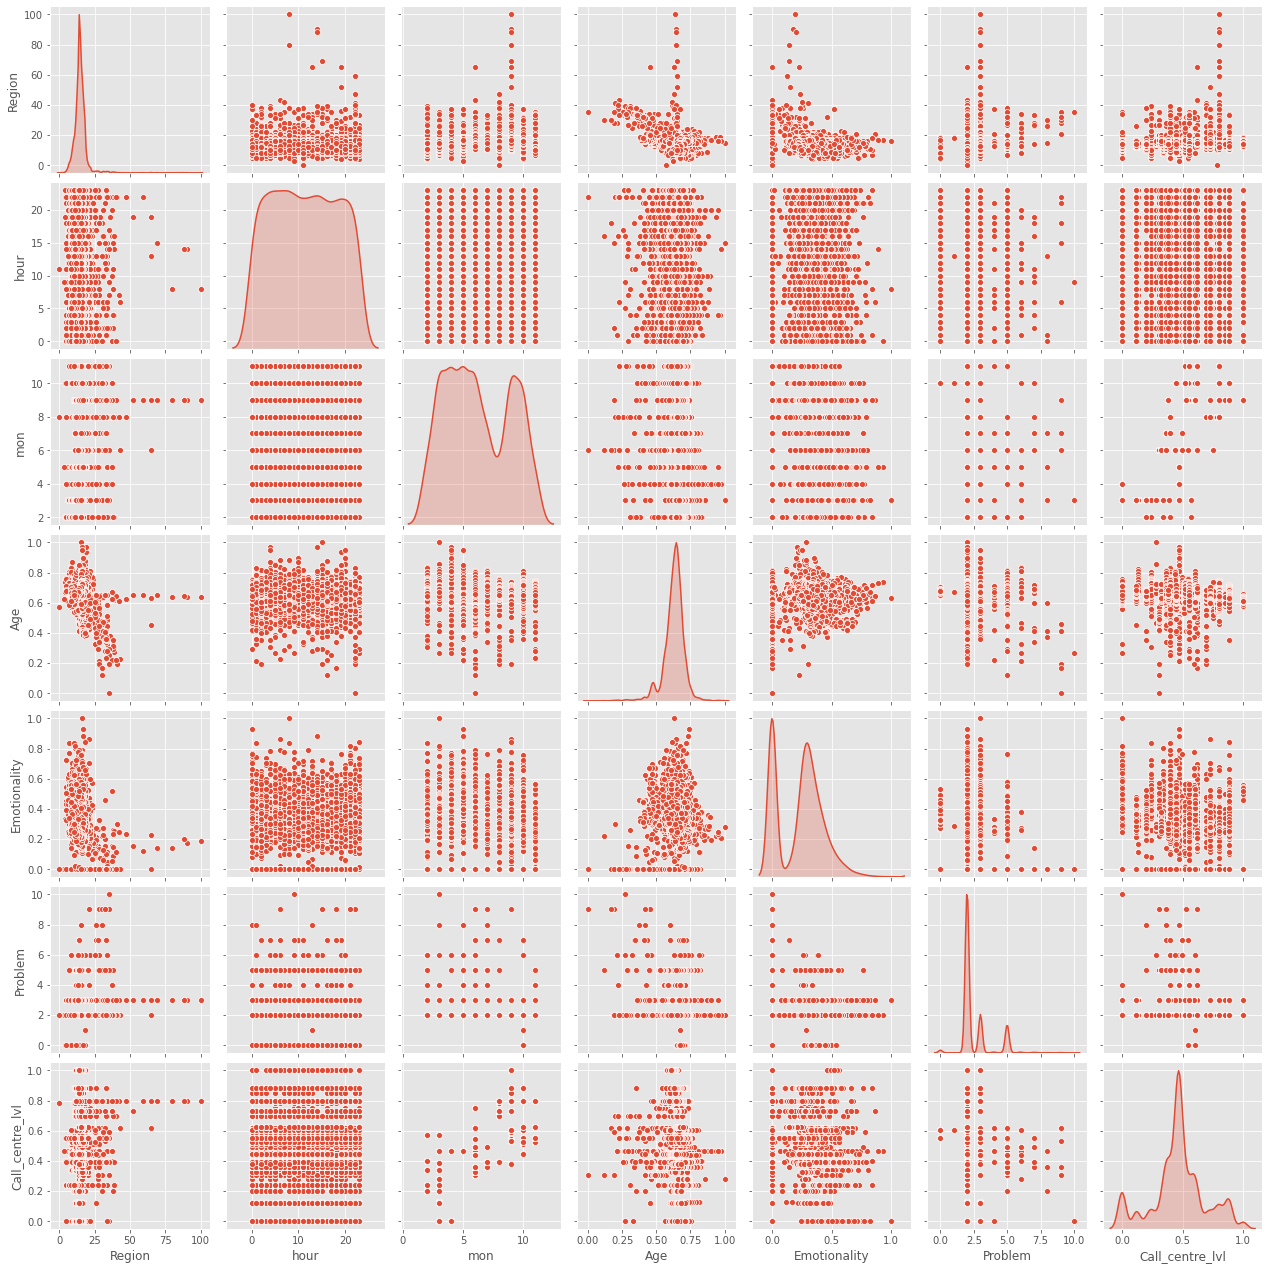

In [9]:
# Постройте pairplot для целочисленных признаков
seaborn.pairplot(data[numeric_cols], diag_kind="kde")

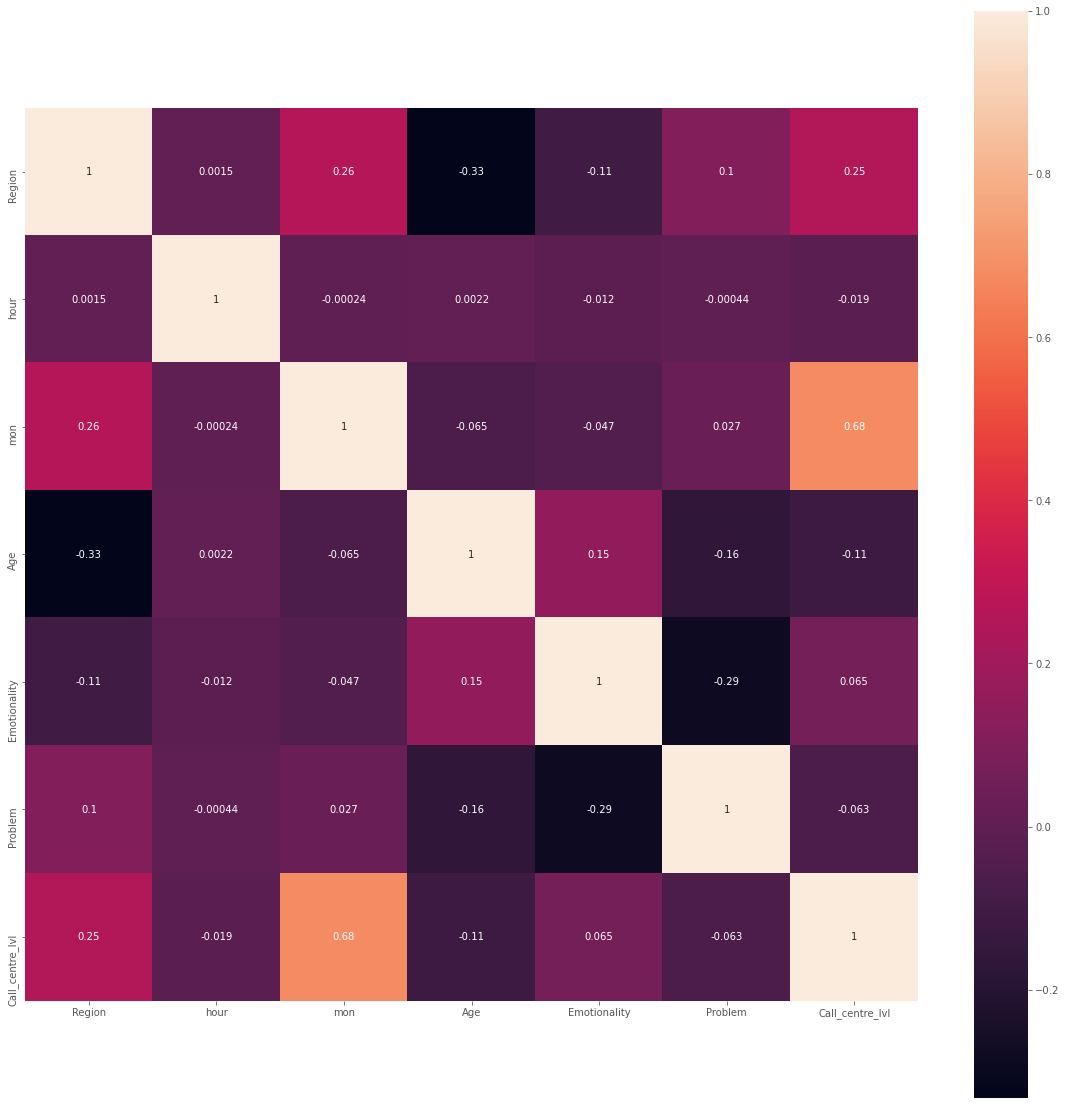

In [10]:
plt.figure(figsize=(20, 20))
seaborn.heatmap(data[numeric_cols].corr(), square = True, annot = True)

In [11]:
#Разделим на Х и у
X = data[numeric_cols + categorical_cols]
y = data['Target']

X_real = X[numeric_cols]
X_cat = X[categorical_cols]

In [12]:
#Выделим уникальные категориальные признаки, закодируем их и подставим в столбец кат признаков преобразованные признаки
X_unic = pd.DataFrame(X_cat.drop_duplicates())

encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_unic.T.to_dict().values())

a = []
for i in range(len(X_unic)):
    a.insert(i, [X_unic.values[i], X_cat_oh[i]])

X_cat_n = []
k = 0
for i in range(X_cat.shape[0]):
    for j in range(len(X_cat_oh)):
        if np.all(X_cat.values[i] == a[j][0]):
            X_cat_n.insert(k, a[j][1])
            k += 1
            break;

In [13]:
#Разобьём на обучающую и тестовую выборку в соотношении 70/30
from sklearn.model_selection import train_test_split

(X_train_real, X_test_real, y_train, y_test) = train_test_split(X_real, y, test_size = 0.3, random_state = 0)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(X_cat_n, test_size = 0.3, random_state = 0)

In [14]:
#Соединим все признаки
X_z = np.hstack([X_real, X_cat_n])
X_train_z = np.hstack([X_train_real, X_train_cat_oh])
X_test_z = np.hstack([X_test_real, X_test_cat_oh])

In [15]:
#Воспользуемся логистической регрессией с L1-регуляризацией (задача бинарной классификации)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

y_train = y_train.astype('int')

optimizer_z = GridSearchCV(estimator = LogisticRegression(penalty='l1', solver='liblinear'), param_grid = param_grid)
optimizer_z.fit(X_train_z, y_train)

optimizer_z.best_estimator_

C:\Users\Public\anaconda 3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda 3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda 3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

In [16]:
print(list(zip(list(map(lambda x : round(x, 2), optimizer_z.best_estimator_.coef_.flatten()[0:7])), numeric_cols)))

[(0.31, 'Region'), (0.01, 'hour'), (-0.01, 'mon'), (3.54, 'Age'), (-0.16, 'Emotionality'), (-0.29, 'Problem'), (-0.76, 'Call_centre_lvl')]


In [17]:
#Посчитаем метрику ROC-AUC
from sklearn.metrics import roc_auc_score, accuracy_score
y_test = y_test.astype('int')
y_z = optimizer_z.predict(X_test_z)
auc_1 = roc_auc_score(y_test, y_z)
auc_1

0.6968859318936848

In [18]:
print(confusion_matrix(y_test,y_z))
print(classification_report(y_test,y_z))

[[639 188]
 [255 418]]
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       827
           1       0.69      0.62      0.65       673

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500



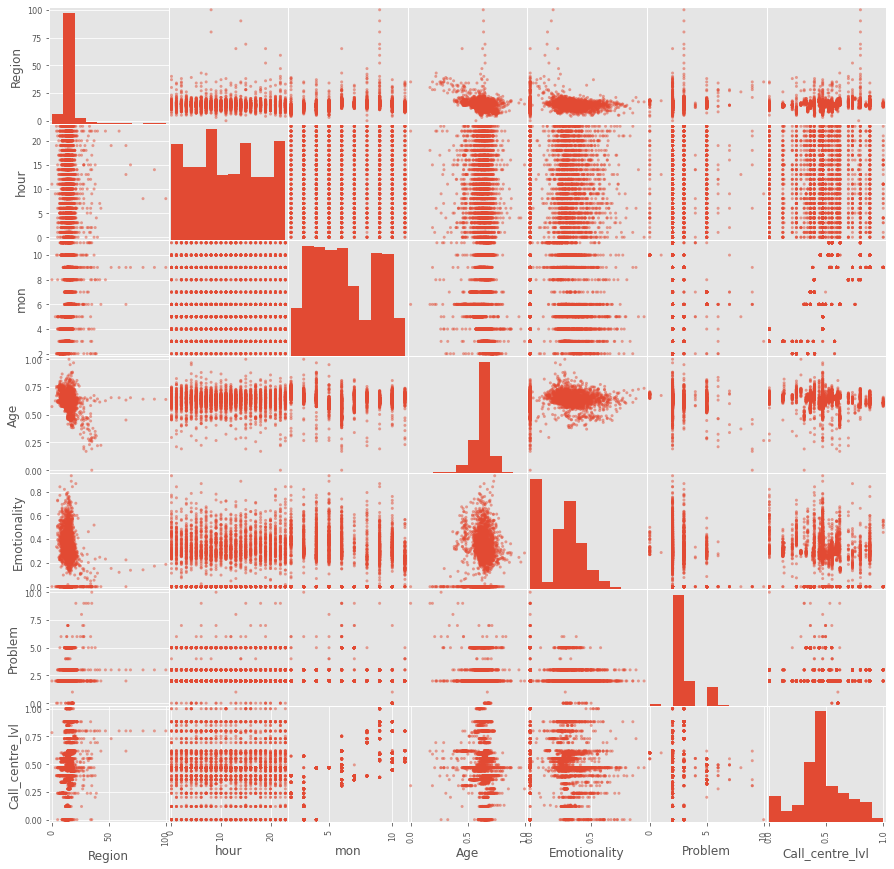

In [19]:
#Посмотрим на данные, нужно масштабировать вещественные признаки
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real, columns=numeric_cols)
list_cols = numeric_cols 
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(15, 15))
plt.show()

In [20]:
#не требуется балансировка классов
print(np.sum(y_train==0))
print(np.sum(y_train==1))

1890
1607


In [21]:
#Разобьём на обучающую и тестовую выборку
numeric_cols_1 = list(set(data.columns.values.tolist()) - set(categorical_cols + ['Target'] + ['Time']))
X_real = X[numeric_cols_1]

In [22]:
#Масштабируем признаки и объединяем
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_real_scale = scale.fit_transform(X_real)

X_real_scale = np.hstack([X_real_scale, X_cat_n])

In [23]:
from sklearn import model_selection
y = y.astype('int').values

## Logistic Regression

In [24]:
#Воспользуемся логистической регрессией с L2-регуляризацией (задача бинарной классификации)
classifiers = []
Y = []
i = 0
skf = model_selection.StratifiedKFold(n_splits = 7, shuffle = True, random_state = 0)
for train_indices, test_indices in skf.split(X_real_scale, y):
    param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
    x_tr = X_real_scale[train_indices]
    y_tr = y[train_indices]
    x_t = X_real_scale[test_indices]
    y_t = y[test_indices]

    optimizer_z = GridSearchCV(estimator = LogisticRegression(penalty='l2', solver='liblinear'), param_grid = param_grid)
    optimizer_z.fit(x_tr, y_tr)
    
    y_z = optimizer_z.best_estimator_.predict(x_t)
    Y.append([y_t, y_z])
    classifiers.append(optimizer_z.best_estimator_)

In [25]:
#Считаем метрику roc-auc
auc = []
acc = []
for i in range(7):
    auc.append(roc_auc_score(Y[i][0], Y[i][1]))
    acc.append(accuracy_score(Y[i][0], Y[i][1]))
auc_2 = np.array(auc).mean()

In [26]:
print(auc_1, auc_2)

0.6968859318936848 0.6897499007979526


In [27]:
print(np.array(acc).mean())

0.6996164524715918


## Random Tree 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_z, y, test_size=0.2)

clf = tree.DecisionTreeClassifier(random_state=1)

scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
print(scores)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[0.8192048  0.78903904 0.78678679]
[[441 106]
 [ 94 359]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       547
           1       0.77      0.79      0.78       453

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



## Random Forest

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_z, y, test_size=0.2)

rf_classifier_low_depth = ensemble.RandomForestClassifier(n_estimators = 50, random_state = 1)

scores = cross_val_score(rf_classifier_low_depth, X_train, y_train, cv=3, scoring='accuracy')
print(scores)

rf_classifier_low_depth.fit(X_train, y_train)

predictions1 = rf_classifier_low_depth.predict(X_test)

print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))

[0.85146287 0.85285285 0.85885886]
[[495  63]
 [ 70 372]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       558
           1       0.86      0.84      0.85       442

    accuracy                           0.87      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.87      0.87      1000



## Метод SVC

### Линейное ядро

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_z, y, test_size=0.2)
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [31]:
y_pred = svclassifier.predict(X_test)

In [32]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[446 114]
 [172 268]]
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       560
           1       0.70      0.61      0.65       440

    accuracy                           0.71      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.71      0.71      1000



### ядро RBF

In [33]:
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[472  88]
 [213 227]]
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       560
           1       0.72      0.52      0.60       440

    accuracy                           0.70      1000
   macro avg       0.70      0.68      0.68      1000
weighted avg       0.70      0.70      0.69      1000



### Полиномиальное ядро

In [34]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[434 126]
 [169 271]]
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       560
           1       0.68      0.62      0.65       440

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000

